In [1]:
import pathlib
import numpy as np
import scipy as sp
from matplotlib import pyplot as plt


import SessionTools.two_photon as st2p


%load_ext autoreload
%autoreload 2 

%matplotlib inline

In [2]:
session_info = {'date': "15_10_2024",
                'genotype_dir': 'EL_hm4Di_R60D05LexA_jRGECO1a/hm4di_control',
                'fly': 'fly4',
                'session': 'closed_loop-000',
                'fictrac_scan_num':0,
                'fictrac_dat_file' :'fictrac-20241015_154742.dat',
                'full_genotype': '+/w-; EL-AD, LexOpjRGECO1a/R60D05-LexA; EL-DBD/UAS-hm4Di',
                'ecl date': '10/6-7/2024',
                'notes': '50 nM DCZ'}


session_info['fictrac_dir']= f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}"
bruker_folder = pathlib.PurePath('/media/mplitt/SSD_storage/2PData')
# pkl_path = pathlib.PurePath(f"/media/mplitt/SSD_storage/fictrac_folder/{session_info['genotype_dir']}/{session_info['date']}/{session_info['fly']}/fly1_1_scan0.pkl")

pp = st2p.preprocessing.EBImagingSession(session_info = session_info, 
                                         bruker_base_dir = bruker_folder,
                                         fictrac_dir = session_info['fictrac_dir'],
                                         fictrac_dat_file = session_info['fictrac_dat_file'],
                                         fictrac_scan_num = session_info['fictrac_scan_num'])
                                         # fictrac_pkl_path=pkl_path)



In [3]:
if False:
    gd = session_info['genotype_dir']
    d = session_info['date']
    f = session_info['fly']
    s = session_info['session']
    outdir = pathlib.PurePath(f'/media/mplitt/SSD_storage/2P_scratch/{gd}/{d}/{f}/{s}/preprocess.pkl')
    pp = st2p.preprocessing.EBImagingSession.from_file(outdir)
    # y_r4d = pp.timeseries['rois_R4d_z']
    y = pp.timeseries['rois_z']
    n_rois=y.shape[1]

In [4]:
pp.extract_metadata()

pp.align_voltage_recording()


In [5]:
pp.align_fictrac()

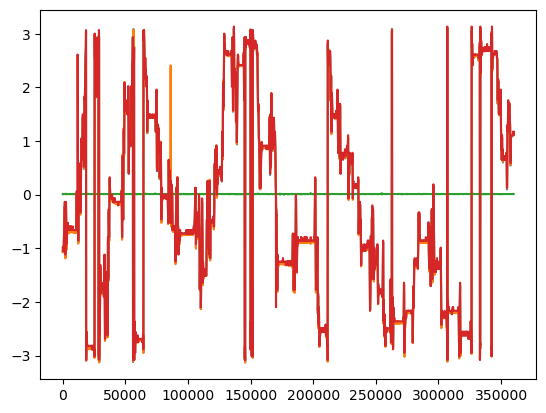

In [6]:
fig, ax = plt.subplots()
time = pp.fictrac_aligned['Time(ms)']
inds = slice(0,100000)
ax.plot(time[inds],pp.fictrac_aligned['integ heading (lab)'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Heading'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Y/Index'].iloc[inds])
ax.plot(time[inds], pp.voltage_recording_aligned[' Arena DAC1'].iloc[inds])

In [7]:
pp.bruker_to_h5(first_chan=1, overwrite=False)
data_corr, shifts, error, diffphase= pp.motion_correct(pp.data)
nap = pp.open_napari()

(262, 321)
[                                        ] | 0% Completed | 409.47 ms

<tifffile.TiffFile 'closed_loop-000…1_000003.ome.tif'> OME series is BinaryOnly, not an OME-TIFF master file 


[########################################] | 100% Completed | 26.38 s


In [8]:
print()

In [9]:
n_rois = 16
nap.make_phase_masks(n_rois=n_rois)
pp.get_layers(nap)
pp.extract_timeseries(max_proj=False)

In [10]:
y = pp.calculate_zscored_F('rois', zscore=False, exp_detrend = True)

In [11]:
pp.save()

In [12]:
y_sm = sp.ndimage.gaussian_filter1d(sp.ndimage.gaussian_filter1d(y-1, 2, axis=-1),.7,axis=1, mode='wrap')
# y_sm = y-1  #sp.ndimage.gaussian_filter1d(y, 1, axis=-1)

x_f,y_f = st2p.utilities.pol2cart(y_sm[-1,:,:],np.linspace(-np.pi,np.pi,num=n_rois)[:,np.newaxis])
rho,phi = st2p.utilities.cart2pol(x_f.mean(axis=0), y_f.mean(axis=0))
print(rho.shape, phi.shape)

heading = -1* pp.voltage_recording_aligned[' Heading'].to_numpy()

_,offset = st2p.utilities.cart2pol(*st2p.utilities.pol2cart(np.ones(heading.shape),phi-heading))

(3492,) (3492,)


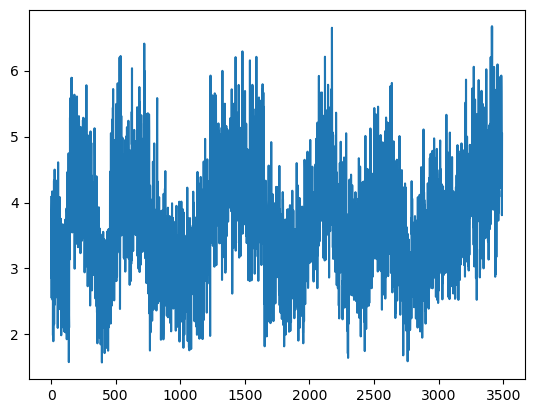

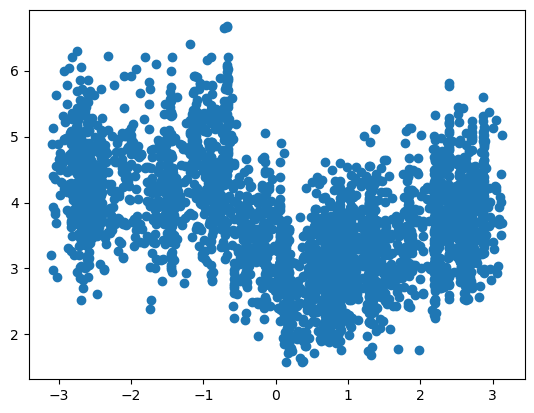

In [13]:
fig, ax= plt.subplots()
ax.plot(pp.timeseries['background'][-1,0,:])
fig, ax= plt.subplots()
ax.scatter(heading, pp.timeseries['background'][-1,0,:])

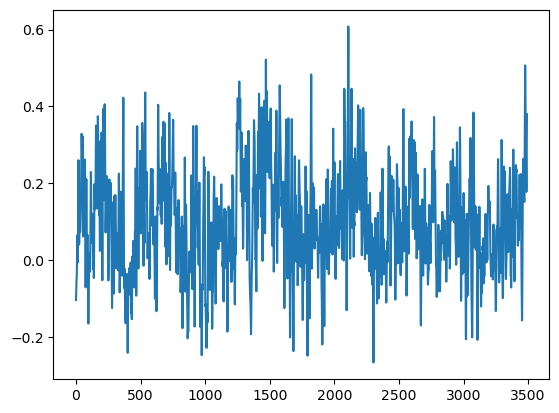

In [14]:
fig,ax = plt.subplots()
ax.plot(y_sm[-1,0,:])

Text(0.5, 1.0, '0.9288194690175638')

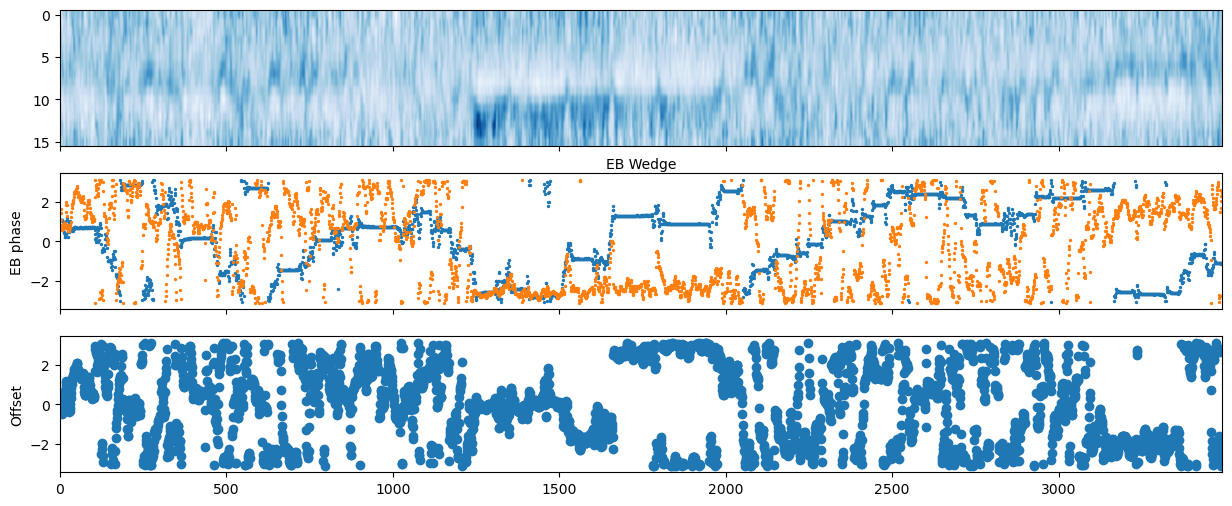

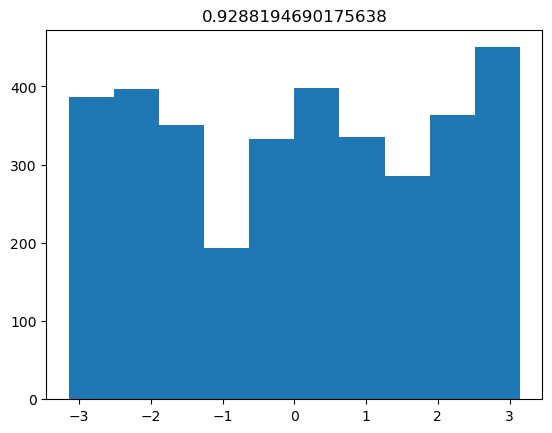

In [15]:
fig, ax= plt.subplots(3,1, figsize=[15,6], sharex=True)
ax[0].imshow(y_sm[-1,::-1,:], aspect='auto', cmap= 'Blues') #, vmin=-1,vmax=1)#, vmin=-1,vmax=1)
# ax[0].scatter(np.arange(y.shape[-1]), 15*(heading+np.pi)/2/np.pi)
ax[0].set_xlabel('EB Wedge')


# print(pp.voltage_recording_aligned.columns)
# fig, ax= plt.subplots()

x = np.arange(y.shape[-1])
# print(y.shape, heading.shape)
ax[1].scatter(x[:]-x[0],heading[:], s=2)
ax[1].scatter(x[:]-x[0], phi[:], s=2)
ax[1].set_ylabel('EB phase')
ax[2].scatter(x[:]-x[0], offset[:])
ax[2].set_ylabel('Offset')
# fig.savefig('/media/mplitt/SSD_storage/fig_scratch/LabMeetings/05_09_2024/hm4d_pilot.pdf')

mask = (heading>.7) | (heading<-.7)
fig, ax= plt.subplots()
ax.hist(offset)
ax.set_title(sp.stats.circvar(offset))

(16,) (16,)


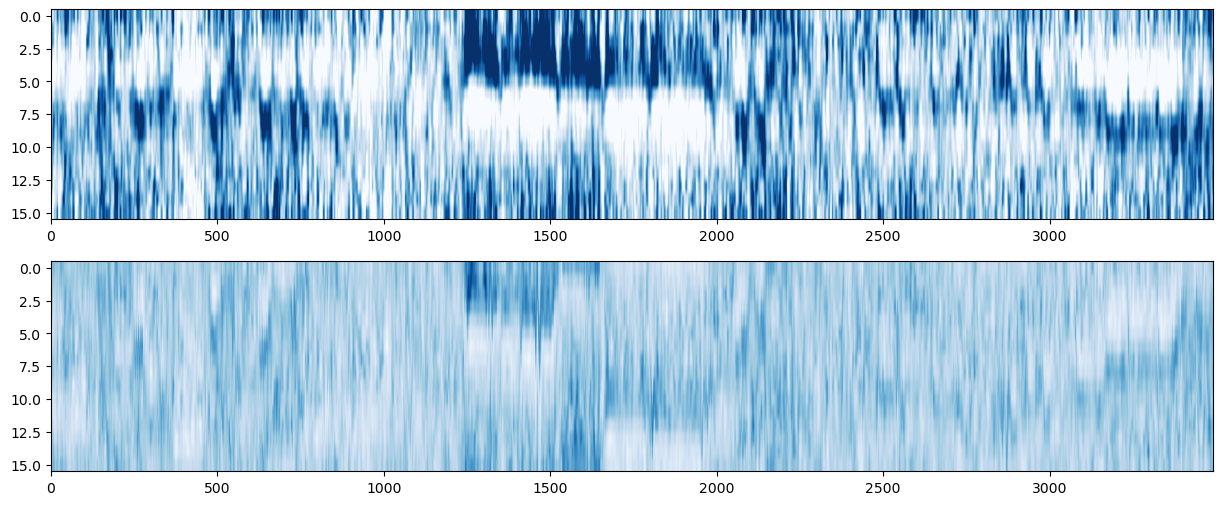

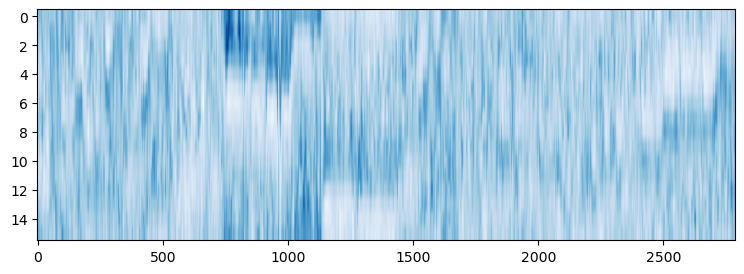

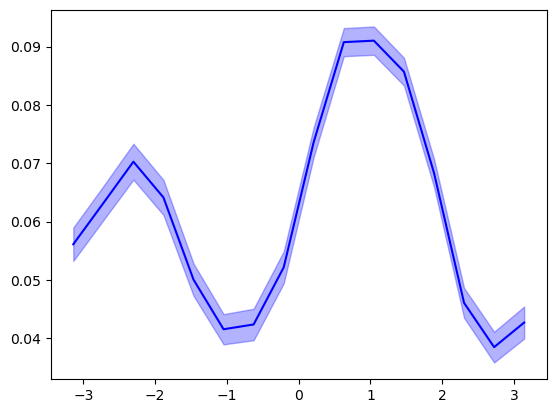

In [16]:
heading_ind = ((n_rois-1)*(heading+np.pi)/2/np.pi).astype(int)
# print(heading_ind, y_sm.shape)

y_sm_heading_aligned = np.zeros_like(y_sm)
for ind in range(heading.shape[0]):
    y_sm_heading_aligned[-1,:,ind] = np.roll(y_sm[-1,:,ind], -heading_ind[ind])
    
fig, ax= plt.subplots(2,1, figsize=[15,6])
ax[0].imshow(y_sm[-1,:, :] , cmap='Blues',aspect='auto',vmin=-.1,vmax=.3)
ax[1].imshow(y_sm_heading_aligned[-1,:,:], cmap='Blues',aspect='auto')#,vmin=-.1,vmax=.3)
# ax[0].imshow(y_sm[0,:, :] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')
# ax[1].imshow(y_sm_heading_aligned[0,:,:] - y_sm[0,:,:].mean(axis=0), cmap='Blues',aspect='auto')

# y_sm_ha = y
mu = y_sm_heading_aligned[:,:,mask].mean(axis=-1)[-1,:]
sem = sp.stats.sem(y_sm_heading_aligned[:,:,mask], axis=-1)[-1,:]
print(mu.shape, sem.shape)
fig, ax = plt.subplots(figsize=[9,3])
ax.imshow(y_sm_heading_aligned[:,:,mask][-1,:,:], cmap='Blues', aspect='auto')#, vmin=-.3, vmax=.1)

fig, ax= plt.subplots()
ax.fill_between(np.linspace(-np.pi, np.pi, num=n_rois), mu-sem, mu+sem, alpha=.3, color='blue')
ax.plot(np.linspace(-np.pi, np.pi, num=n_rois), mu, color='blue')

In [23]:
print(sp.stats.circvar(offset[mask]))

0.664734414532739


0.07743050487927705 0.015754068268983203


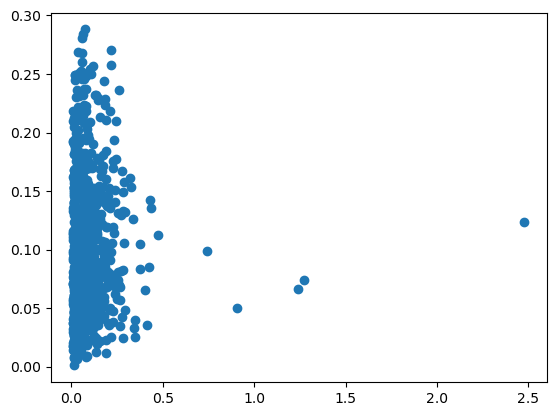

In [24]:
fig, ax = plt.subplots()
dh = np.angle(np.exp(1j*np.ediff1d(pp.voltage_recording_aligned[' Heading'].to_numpy(), to_end=0)))
mask = dh>.01
# ax.scatter(np.abs(dh[mask]),y_sm[:,:,mask].mean(axis=1))
ax.scatter(np.abs(dh[mask]),rho[mask])

# r,p = sp.stats.spearmanr(np.abs(dh[mask]), y_sm[:,:,mask].mean(axis=1).ravel())
r,p = sp.stats.spearmanr(np.abs(dh[mask]), rho[mask])
print(r,p)

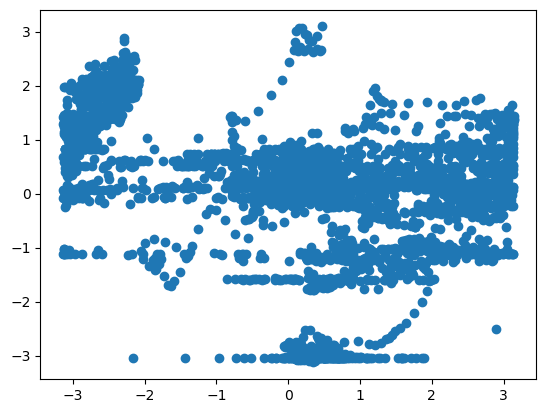

In [25]:
fig,ax = plt.subplots()
ax.scatter(phi, heading)

(array([533., 257.,  72., 115., 344., 646., 331., 286., 298., 413.]),
 array([-3.13943546e+00, -2.51155120e+00, -1.88366693e+00, -1.25578267e+00,
        -6.27898400e-01, -1.41337275e-05,  6.27870132e-01,  1.25575440e+00,
         1.88363866e+00,  2.51152293e+00,  3.13940720e+00]),
 <BarContainer object of 10 artists>)

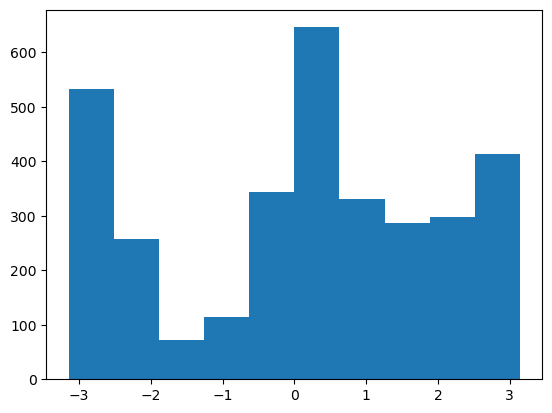

In [21]:
fig, ax = plt.subplots()
ax.hist(phi)